In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [ ]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '135-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
OOF_PREDS_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/oof.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [ ]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [ ]:
#@title
config = {
  "HEIGHT": 512,
  "WIDTH": 512,
  "CHANNELS": 3,
  "BATCH_SIZE": 16,
  "EPOCHS": 110,
  "LEARNING_RATE": 5e-3,
  "ES_PATIENCE": 20,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-512x512',
  "INFERENCE": True
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config['LEARNING_RATE'] = config['LEARNING_RATE'] * config['BATCH_SIZE'] / 512 * REPLICAS
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 16,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-512x512',
 'EPOCHS': 110,
 'ES_PATIENCE': 20,
 'HEIGHT': 512,
 'INFERENCE': True,
 'LEARNING_RATE': 0.00125,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 512}

# Load data

In [ ]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b'
GCS_2019_PATH = 'gs://kds-25423645f76650f9220fbd3613366c3c5a524b3a7d7663b6e3137c57'
GCS_MALIGNANT_PATH = 'gs://kds-0d477718418961fee4483712e6a7f1ce526d038c6ef905940ee637b8'

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [ ]:
#@title
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [ ]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim, dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


def get_dataset_sampling(files, augment=None, shuffle=False, repeat=False, 
                         labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.00125 to 7.69e-06


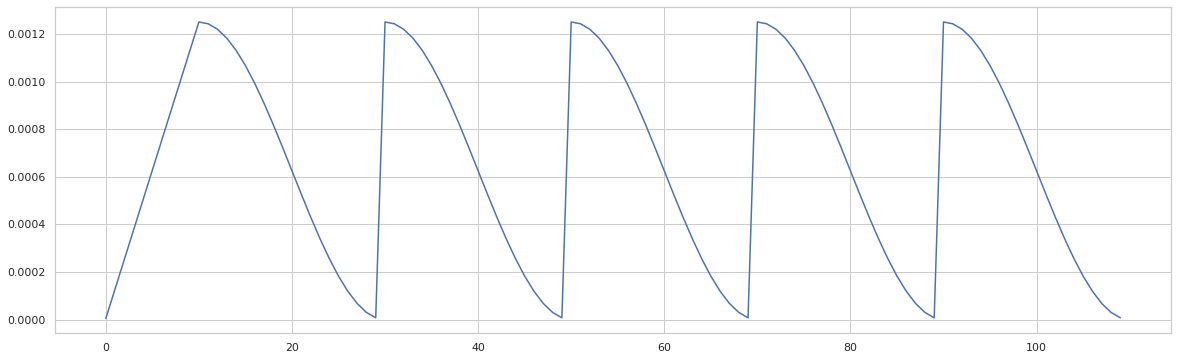

In [ ]:
#@title
def cosine_with_hard_restarts_schedule_with_warmup(epoch):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function with several hard restarts, after a warmup
    period during which it increases linearly between 0 and 1.
    """
    lr_start   = 5e-6
    lr_max     = config['LEARNING_RATE']
    lr_min     = 1e-6
    warmup_epochs = 10
    num_cycles = 5
    total_epochs = config['EPOCHS']
    
    if epoch < warmup_epochs:
        lr = (lr_max - lr_start) / warmup_epochs * epoch + lr_start
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = lr_max * (0.5 * (1.0 + tf.math.cos(math.pi * ((num_cycles * progress) % 1.0))))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

def get_lr_callback():
    lr_callback = tf.keras.callbacks.LearningRateScheduler(cosine_with_hard_restarts_schedule_with_warmup, verbose=False)
    return lr_callback

total_epochs = config['EPOCHS']
rng = [i for i in range(0, total_epochs)]
y = [cosine_with_hard_restarts_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [ ]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid', kernel_initializer='zeros', name='output')(x)

    model = Model(inputs=input_image, outputs=output)
    
    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

    return model

# Training

In [ ]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []; oof_pred_last = []
preds = np.zeros((len(test), 1))
preds_last = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    TRAINING_MALIG_FILENAMES = tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    TRAINING_MALIG_FILENAMES += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    np.random.shuffle(TRAINING_MALIG_FILENAMES)
    ds_regular = get_dataset_sampling(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                      dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_malig = get_dataset_sampling(TRAINING_MALIG_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    # Resampled TF Dataset
    resampled_ds = tf.data.experimental.sample_from_datasets([ds_regular, ds_malig], weights=[0.6, 0.4])
    resampled_ds = resampled_ds.batch(config['BATCH_SIZE'] * REPLICAS).prefetch(AUTO)

    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    steps_per_epoch = (count_data_items(TRAINING_FILENAMES) / 0.6) / 10
    
    ### MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

    model_path_best_auc = f'{MODEL_BASE_PATH}model_{fold}_auc.h5'
    model_path_best_loss = f'{MODEL_BASE_PATH}model_{fold}_loss.h5'
    # model_path_last = f'{MODEL_BASE_PATH}model_{fold}_last.h5'

    es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], verbose=1)
    checkpoint_auc = ModelCheckpoint(model_path_best_auc, monitor='val_auc', mode='max', save_best_only=True,
                                     save_weights_only=True, verbose=0)
    checkpoint_loss = ModelCheckpoint(model_path_best_loss, monitor='val_loss', mode='min', save_best_only=True,
                                      save_weights_only=True, verbose=0)
    checkpoint_loss.epochs_since_last_save = -10 # Warmup epochs
   
    ### TRAIN
    history = model.fit(resampled_ds, 
                        validation_data=get_dataset(files_valid, augment=None, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=(steps_per_epoch/config['BATCH_SIZE']//REPLICAS), 
                        callbacks=[es, checkpoint_auc, checkpoint_loss, get_lr_callback()], 
                        epochs=config['EPOCHS'], 
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    # model.save_weights(model_path_last)

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                           labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    ### Load best model weights (AUC)
    model.load_weights(model_path_best_auc)
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA (AUC)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred_last.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA (AUC)...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds_last[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    ### Load best model weights (Loss)
    model.load_weights(model_path_best_loss)
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA (Loss)...')
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'), axis=1))
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA (Loss)...')
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    ### RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    auc_last = roc_auc_score(oof_tar[-1], oof_pred_last[-1])
    auc_blend = roc_auc_score(oof_tar[-1], np.mean([oof_pred[-1], oof_pred_last[-1]], axis=0))
    oof_val.append(np.max(history['val_auc']))
    print(f'#### FOLD {fold+1} OOF AUC = {oof_val[-1]:.3f}, with TTA (Loss) = {auc:.3f}, with TTA (AUC) = {auc_last:.3f}, with TTA (Blend) = {auc_blend:.3f}')

INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
Epoch 1/110
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


47/47 - 49s - loss: 0.6923 - auc: 0.5403 - val_loss: 0.6935 - val_auc: 0.4918
Epoch 2/110
47/47 - 32s - loss: 0.5410 - auc: 0.8307 - val_loss: 0.4664 - val_auc: 0.5114
Epoch 3/110
47/47 - 32s - loss: 0.4623 - auc: 0.8825 - val_loss: 0.3956 - val_auc: 0.6678
Epoch 4/110
47/47 - 32s - loss: 0.4447 - auc: 0.8934 - val_loss: 0.3068 - val_auc: 0.7655
Epoch 5/110
47/47 - 33s - loss: 0.4390 - auc: 0.8965 - val_loss: 0.2080 - val_auc: 0.8405
Epoch 6/110
47/47 - 31s - loss: 0.3932 - auc: 0.9238 - val_loss: 0.2465 - val_auc: 0.8287
Epoch 7/110
47/47 - 33s - loss: 0.3911 - auc: 0.9249 - val_loss: 0.2328 - val_auc: 0.8683
Epoch 8/110
47/47 - 30s - loss: 0.3593 - auc: 0.9400 - val_loss: 0.2281 - val_auc: 0.8426
Epoch 9/110
47/47 - 32s - loss: 0.3494 - auc: 0.9446 - val_loss: 0.2484 - val_auc: 0.8822
Epoch 10/110
47/47 - 31s - loss: 0.3338 - auc: 0.9518 - val_loss: 0.2768 - val_auc: 0.7726
Epoch 11/110
47/47 - 32s - loss: 0.3703 - auc: 0.9354 - val_loss: 0.2240 - val_auc: 0.8310
Epoch 12/110
47/47 -

320/319 - 222s
Predicting Test with TTA (AUC)...


537/536 - 368s
Predicting OOF with TTA (Loss)...


320/319 - 215s
Predicting Test with TTA (Loss)...


537/536 - 360s
#### FOLD 1 OOF AUC = 0.930, with TTA (Loss) = 0.864, with TTA (AUC) = 0.925, with TTA (Blend) = 0.927


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
Epoch 1/110


47/47 - 49s - loss: 0.6922 - auc: 0.5509 - val_loss: 0.6936 - val_auc: 0.4981
Epoch 2/110
47/47 - 33s - loss: 0.5488 - auc: 0.8227 - val_loss: 0.4797 - val_auc: 0.5510
Epoch 3/110
47/47 - 32s - loss: 0.4576 - auc: 0.8852 - val_loss: 0.5150 - val_auc: 0.6820
Epoch 4/110
47/47 - 32s - loss: 0.4619 - auc: 0.8818 - val_loss: 0.2971 - val_auc: 0.7525
Epoch 5/110
47/47 - 32s - loss: 0.4314 - auc: 0.9026 - val_loss: 0.2943 - val_auc: 0.8485
Epoch 6/110
47/47 - 31s - loss: 0.4000 - auc: 0.9201 - val_loss: 0.2999 - val_auc: 0.8435
Epoch 7/110
47/47 - 31s - loss: 0.3598 - auc: 0.9399 - val_loss: 0.3488 - val_auc: 0.8285
Epoch 8/110
47/47 - 32s - loss: 0.3435 - auc: 0.9476 - val_loss: 0.5955 - val_auc: 0.8485
Epoch 9/110
47/47 - 31s - loss: 0.3539 - auc: 0.9429 - val_loss: 0.2958 - val_auc: 0.8245
Epoch 10/110
47/47 - 31s - loss: 0.3462 - auc: 0.9468 - val_loss: 0.2155 - val_auc: 0.8430
Epoch 11/110
47/47 - 32s - loss: 0.3731 - auc: 0.9336 - val_loss: 0.2170 - val_auc: 0.8467
Epoch 12/110
47/47 -

320/319 - 226s
Predicting Test with TTA (AUC)...


537/536 - 360s
Predicting OOF with TTA (Loss)...


320/319 - 218s
Predicting Test with TTA (Loss)...


537/536 - 363s
#### FOLD 2 OOF AUC = 0.909, with TTA (Loss) = 0.822, with TTA (AUC) = 0.914, with TTA (Blend) = 0.907


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Epoch 1/110


47/47 - 50s - loss: 0.6923 - auc: 0.5378 - val_loss: 0.6939 - val_auc: 0.4991
Epoch 2/110
47/47 - 32s - loss: 0.5431 - auc: 0.8300 - val_loss: 0.4188 - val_auc: 0.5300
Epoch 3/110
47/47 - 32s - loss: 0.4566 - auc: 0.8852 - val_loss: 0.2182 - val_auc: 0.7155
Epoch 4/110
47/47 - 33s - loss: 0.4530 - auc: 0.8885 - val_loss: 0.3267 - val_auc: 0.8108
Epoch 5/110
47/47 - 32s - loss: 0.4303 - auc: 0.9022 - val_loss: 0.1891 - val_auc: 0.8973
Epoch 6/110
47/47 - 31s - loss: 0.4076 - auc: 0.9157 - val_loss: 0.2195 - val_auc: 0.8919
Epoch 7/110
47/47 - 32s - loss: 0.3951 - auc: 0.9230 - val_loss: 0.2081 - val_auc: 0.9008
Epoch 8/110
47/47 - 30s - loss: 0.3657 - auc: 0.9380 - val_loss: 0.2045 - val_auc: 0.8966
Epoch 9/110
47/47 - 31s - loss: 0.3498 - auc: 0.9445 - val_loss: 0.2658 - val_auc: 0.8803
Epoch 10/110
47/47 - 31s - loss: 0.3498 - auc: 0.9436 - val_loss: 0.2152 - val_auc: 0.8740
Epoch 11/110
47/47 - 32s - loss: 0.3738 - auc: 0.9342 - val_loss: 0.9650 - val_auc: 0.7769
Epoch 12/110
47/47 -

320/319 - 224s
Predicting Test with TTA (AUC)...


537/536 - 364s
Predicting OOF with TTA (Loss)...


320/319 - 228s
Predicting Test with TTA (Loss)...


537/536 - 361s
#### FOLD 3 OOF AUC = 0.927, with TTA (Loss) = 0.906, with TTA (AUC) = 0.940, with TTA (Blend) = 0.941


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Epoch 1/110


47/47 - 49s - loss: 0.6925 - auc: 0.5274 - val_loss: 0.6935 - val_auc: 0.4865
Epoch 2/110
47/47 - 32s - loss: 0.5447 - auc: 0.8253 - val_loss: 0.3081 - val_auc: 0.5427
Epoch 3/110
47/47 - 33s - loss: 0.4692 - auc: 0.8771 - val_loss: 0.2715 - val_auc: 0.7665
Epoch 4/110
47/47 - 32s - loss: 0.4539 - auc: 0.8877 - val_loss: 0.4923 - val_auc: 0.8307
Epoch 5/110
47/47 - 33s - loss: 0.4231 - auc: 0.9064 - val_loss: 0.2509 - val_auc: 0.8776
Epoch 6/110
47/47 - 33s - loss: 0.4014 - auc: 0.9194 - val_loss: 0.2132 - val_auc: 0.8974
Epoch 7/110
47/47 - 31s - loss: 0.3754 - auc: 0.9326 - val_loss: 0.2179 - val_auc: 0.8746
Epoch 8/110
47/47 - 31s - loss: 0.3518 - auc: 0.9441 - val_loss: 0.3267 - val_auc: 0.8257
Epoch 9/110
47/47 - 31s - loss: 0.3447 - auc: 0.9470 - val_loss: 0.3757 - val_auc: 0.8931
Epoch 10/110
47/47 - 30s - loss: 0.3749 - auc: 0.9329 - val_loss: 0.2366 - val_auc: 0.8763
Epoch 11/110
47/47 - 32s - loss: 0.3765 - auc: 0.9322 - val_loss: 0.2496 - val_auc: 0.8684
Epoch 12/110
47/47 -

319/318 - 222s
Predicting Test with TTA (AUC)...


537/536 - 363s
Predicting OOF with TTA (Loss)...


319/318 - 216s
Predicting Test with TTA (Loss)...


537/536 - 365s
#### FOLD 4 OOF AUC = 0.927, with TTA (Loss) = 0.906, with TTA (AUC) = 0.928, with TTA (Blend) = 0.927


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.122.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]
Epoch 1/110


47/47 - 51s - loss: 0.6925 - auc: 0.5379 - val_loss: 0.6932 - val_auc: 0.4930
Epoch 2/110
47/47 - 32s - loss: 0.5554 - auc: 0.8214 - val_loss: 0.4185 - val_auc: 0.5392
Epoch 3/110
47/47 - 32s - loss: 0.4592 - auc: 0.8835 - val_loss: 0.2788 - val_auc: 0.7342
Epoch 4/110
47/47 - 33s - loss: 0.4544 - auc: 0.8861 - val_loss: 0.3380 - val_auc: 0.8032
Epoch 5/110
47/47 - 32s - loss: 0.4208 - auc: 0.9085 - val_loss: 0.3138 - val_auc: 0.8304
Epoch 6/110
47/47 - 32s - loss: 0.4137 - auc: 0.9122 - val_loss: 0.3408 - val_auc: 0.8694
Epoch 7/110
47/47 - 31s - loss: 0.3916 - auc: 0.9253 - val_loss: 0.2132 - val_auc: 0.8677
Epoch 8/110
47/47 - 31s - loss: 0.3450 - auc: 0.9480 - val_loss: 0.2548 - val_auc: 0.8648
Epoch 9/110
47/47 - 31s - loss: 0.3578 - auc: 0.9411 - val_loss: 0.2135 - val_auc: 0.8426
Epoch 10/110
47/47 - 31s - loss: 0.3547 - auc: 0.9434 - val_loss: 0.3065 - val_auc: 0.8613
Epoch 11/110
47/47 - 34s - loss: 0.3578 - auc: 0.9414 - val_loss: 0.2364 - val_auc: 0.8789
Epoch 12/110
47/47 -

321/320 - 223s
Predicting Test with TTA (AUC)...


537/536 - 360s
Predicting OOF with TTA (Loss)...


321/320 - 217s
Predicting Test with TTA (Loss)...


537/536 - 363s
#### FOLD 5 OOF AUC = 0.920, with TTA (Loss) = 0.911, with TTA (AUC) = 0.929, with TTA (Blend) = 0.928


## Model loss graph

Fold: 1


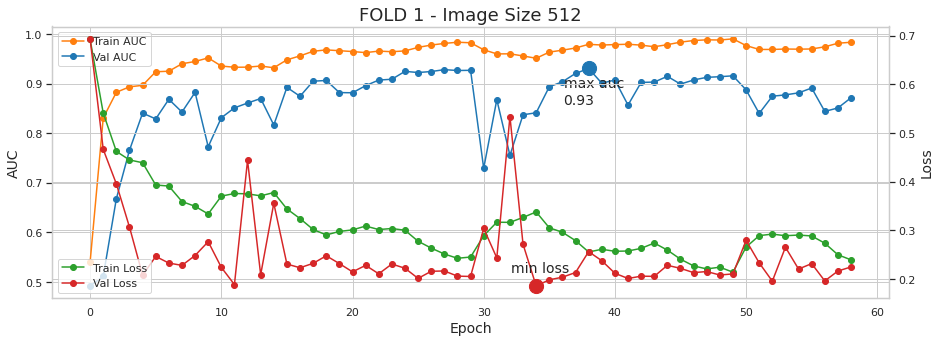

Fold: 2


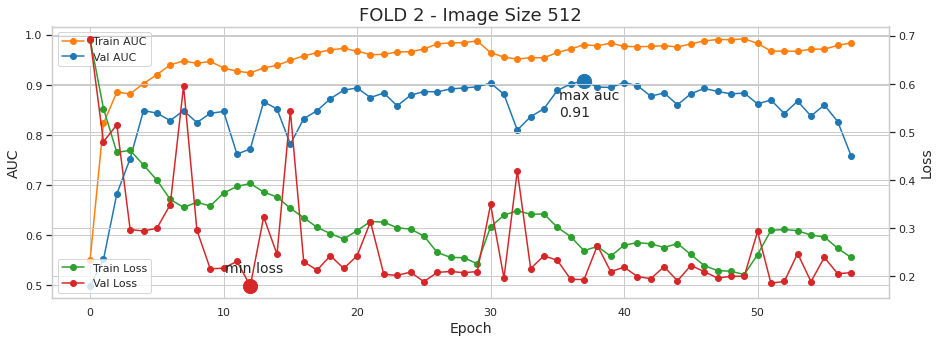

Fold: 3


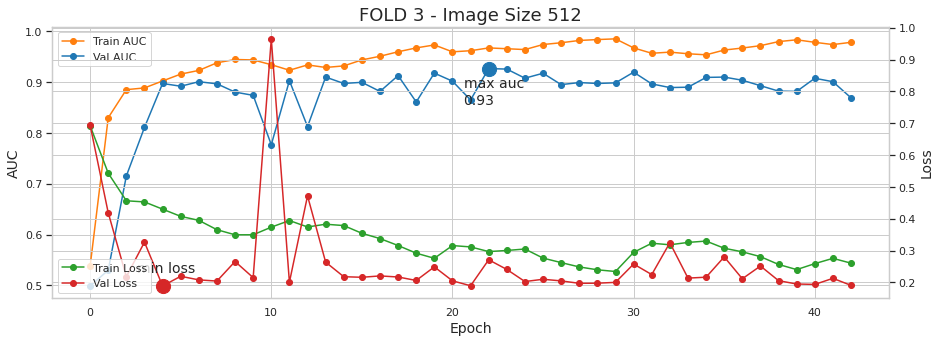

Fold: 4


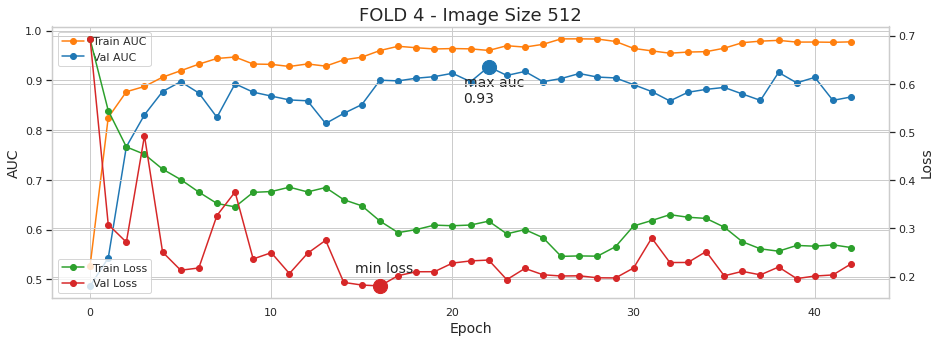

Fold: 5


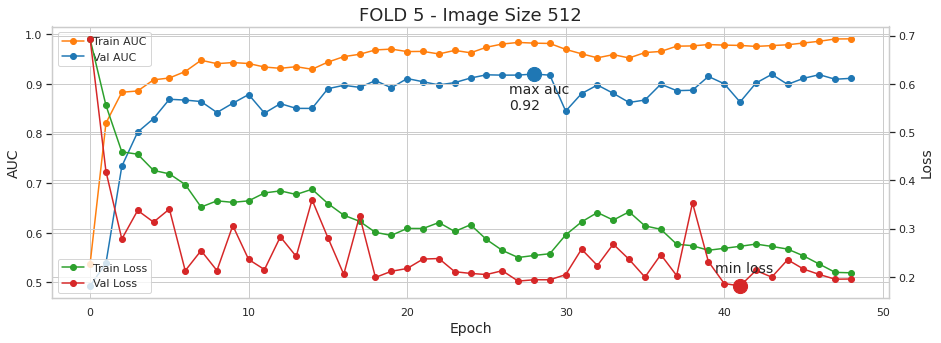

In [ ]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    epochs = np.arange(len(history['loss']))
    plt.figure(figsize=(15,5))
    plt.plot(epochs, history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(epochs, history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(epochs, history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(epochs, history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

# Model evaluation

In [ ]:
#@title
# COMPUTE OVERALL OOF AUC
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)

oof = np.concatenate(oof_pred)
oof_last = np.concatenate(oof_pred_last)
oof_blend = np.mean([oof, oof_last], axis=0)

auc = roc_auc_score(true, oof)
auc_last = roc_auc_score(true, oof_last)
auc_blend = roc_auc_score(true, oof_blend)
print(f'Overall OOF AUC with TTA = {auc:.3f}, with TTA (Last) = {auc_last:.3f}, with TTA (Blend) = {auc_blend:.3f}')

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, fold=folds, target=true, pred=oof, 
                           pred_last=oof_last, pred_blend=oof_blend))
df_oof.to_csv(OOF_PREDS_PATH, index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.875, with TTA (Last) = 0.918, with TTA (Blend) = 0.921


,image_name,fold,target,pred,pred_last,pred_blend
0,ISIC_2637011,0,0,0.029706,0.091301,0.060503
1,ISIC_0076262,0,0,0.007435,0.091833,0.049634
2,ISIC_0074268,0,0,0.009668,0.009984,0.009826
3,ISIC_0015719,0,0,0.010487,0.004246,0.007367
4,ISIC_0082543,0,0,0.005473,0.028130,0.016801


# Visualize test predictions

Test predictions 90|10892
Test predictions (last) 560|10422
Top 10 samples


,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.012441,0.021457,0.016949
1443,ISIC_0052349,0.021524,0.019208,0.020366
3120,ISIC_0058510,0.030729,0.032694,0.031712
4870,ISIC_0073313,0.023039,0.031443,0.027241
5494,ISIC_0073502,0.041003,0.154272,0.097638
4537,ISIC_0074618,0.029034,0.060139,0.044587
4819,ISIC_0076801,0.029952,0.089614,0.059783
7203,ISIC_0077586,0.046755,0.102948,0.074852
10897,ISIC_0082004,0.112345,0.230861,0.171603
5093,ISIC_0082785,0.024980,0.034392,0.029686


Top 10 positive samples


,image_name,target,target_last,target_blend
2280,ISIC_0112420,0.656992,0.935259,0.796126
9372,ISIC_0367988,0.523360,0.690520,0.606940
10045,ISIC_0385865,0.522883,0.665054,0.593968
1018,ISIC_0391046,0.656404,0.876784,0.766594
10750,ISIC_0481105,0.644755,0.919991,0.782373
7421,ISIC_0539432,0.744381,0.939483,0.841932
10348,ISIC_0634896,0.759855,0.808274,0.784065
7186,ISIC_0637104,0.648738,0.872435,0.760586
8334,ISIC_1177164,0.662992,0.829356,0.746174
9187,ISIC_1212424,0.576252,0.918006,0.747129


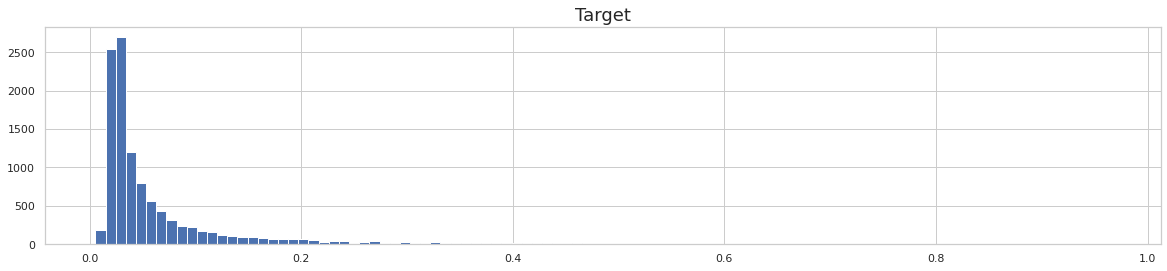

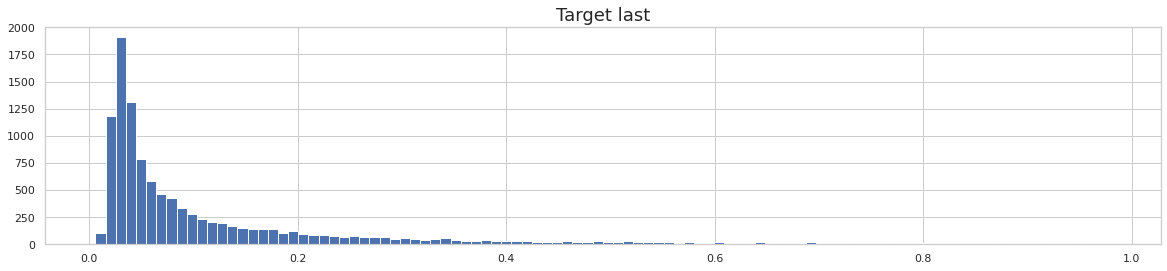

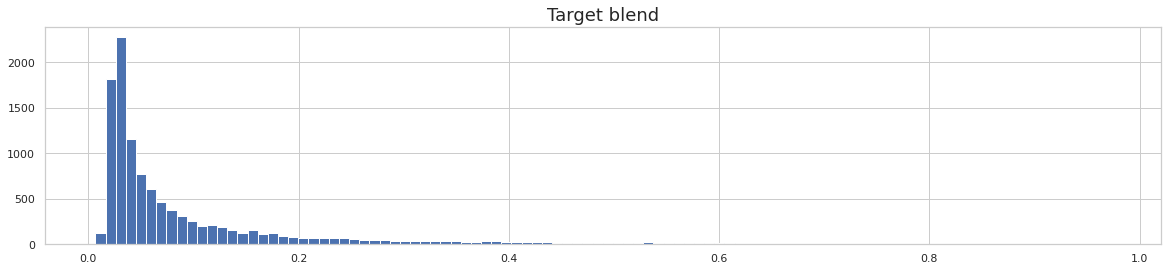

In [ ]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0], target_last=preds_last[:,0]))
submission['target_blend'] = (submission['target'] * .5) +  (submission['target_last'] * .5)
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")
print(f"Test predictions (last) {len(submission[submission['target_last'] > .5])}|{len(submission[submission['target_last'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target'], bins=100)
plt.title('Target', size=18)
plt.show()

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target_last'], bins=100)
plt.title('Target last', size=18)
plt.show()

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target_blend'], bins=100)
plt.title('Target blend', size=18)
plt.show()

# Test set predictions

In [ ]:
#@title
display(submission.head(10))
display(submission.describe().T)

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
9905,ISIC_0052060,0.012441,0.021457,0.016949
1443,ISIC_0052349,0.021524,0.019208,0.020366
3120,ISIC_0058510,0.030729,0.032694,0.031712
4870,ISIC_0073313,0.023039,0.031443,0.027241
5494,ISIC_0073502,0.041003,0.154272,0.097638
4537,ISIC_0074618,0.029034,0.060139,0.044587
4819,ISIC_0076801,0.029952,0.089614,0.059783
7203,ISIC_0077586,0.046755,0.102948,0.074852
10897,ISIC_0082004,0.112345,0.230861,0.171603
5093,ISIC_0082785,0.024980,0.034392,0.029686


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.067914,0.090650,0.005413,0.024625,0.034569,0.067756,0.964456
target_last,10982.0,0.126957,0.164179,0.005748,0.032466,0.057292,0.145135,0.979163
target_blend,10982.0,0.097436,0.125010,0.006723,0.028968,0.046761,0.107521,0.971764
